# Weather Data Preprocessing

## Set up

In [79]:
%matplotlib inline

import logging
import itertools
import json
import os
import pickle
import urllib2
import folium
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap
from datetime import datetime
from os import listdir
from os.path import isfile, join
from src.data.parse_dataset import parse_json_files, parse_json_file, get_file_list, parse_dir
from IPython.display import Image
from datetime import date

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Data Collection

### Single Weather Station Approach

Set the time period for which data will be collected

In [80]:
start_date = date(2016, 5, 15)
end_date = date(2016, 6, 28)

days = pd.date_range(start=start_date, end=end_date, closed='left')

Download the data from Wunderground 

In [43]:
def download(url_string, file_name):
    """Download the given resource to the given file"""
    
    response = urllib2.urlopen(url_string)
    with open(file_name, "wb") as f:
        f.write(response.read())

In [44]:
path = '/home/jfconavarrete/Documents/Work/Dissertation/spts-uoe/data/raw/weather'
lhr_url = 'http://api.wunderground.com/api/8494fbcae3235601/history_%s/q/UK/London.json'

# iterate through all days and stations
for i,day in enumerate(days):
    url_string = lhr_url % (day.strftime('%Y%m%d'))
    file_name = '%s/WEATHER-%s.json' % (path, day.strftime('%Y-%m-%d'))
    
    logger.info('Downloading %s', url_string)
    download(url_string, file_name)
    
    # sleep 60 seconds every 10 requests due to API restrictions 
    if (i % 10) == 9:
        time.sleep(60)

## Data Parsing

Parse the JSON data files

In [81]:
def parse_weather(json_obj):
    """Parses Wunderground API History JSON response"""
    
    return [parse_observation(element) for element in json_obj['history']['observations']]

def parse_observation(observation):
    """Parses a JSON observation object to a dictionary"""
    
    reading = {
        'Timestamp': observation['utcdate']['pretty'],
        'Temp': observation['tempm'],
        'DewPt': observation['dewptm'],
        'Humidity': observation['hum'],
        'WindSpeed': observation['wspdm'],
        'WindDirD': observation['wdird'],
        'Visibility': observation['vism'],
        'Pressure': observation['pressurem'],
        'WindChill': observation['windchillm'],
        'Precipitation': observation['precipm'],
        'Condition': observation['conds'],
        'Fog': observation['fog'],
        'Rain': observation['rain'],
        'Snow': observation['snow'],
        'Hail': observation['hail'],
        'Thunder': observation['thunder'],
        'Tornado': observation['tornado'],
    }

    return reading

In [82]:
def get_file_date(file_name):
    """Gets the file's date"""
    
    file_basename = os.path.basename(file_name)
    idx = file_basename.find('-')
    file_date = file_basename[idx + 1:]
    return datetime.strptime(file_date, '%Y-%m-%d.json')

Convert the raw data to a Pandas DataFrame

In [83]:
records = parse_dir('/home/jfconavarrete/Documents/Work/Dissertation/spts-uoe/data/raw/weather', 
                    parse_weather, sort_fn=get_file_date)

weather_dataset = pd.DataFrame(list(itertools.chain.from_iterable(records)))

## Technically Correct Data

In [84]:
# replace missing values
replace_empty = lambda col: col.replace('T', np.nan).replace('N/A', np.nan).replace('', np.nan)
replace_na = lambda col: col.replace('-9999.00', np.nan).replace('-9999', np.nan).replace('-9999.0', np.nan).replace('-999', np.nan)
weather_dataset = weather_dataset.apply(replace_empty, axis=1).apply(replace_na, axis=1)

# convert columns to their appropriate datatypes
weather_dataset['Fog'] = weather_dataset['Fog'].astype('int8')
weather_dataset['Hail'] = weather_dataset['Hail'].astype('int8')
weather_dataset['Rain'] = weather_dataset['Rain'].astype('int8')
weather_dataset['Snow'] = weather_dataset['Snow'].astype('int8')
weather_dataset['Tornado'] = weather_dataset['Tornado'].astype('int8')
weather_dataset['Thunder'] = weather_dataset['Snow'].astype('int8')

weather_dataset['Precipitation'] = weather_dataset['Precipitation'].astype('float32')
weather_dataset['Visibility'] = weather_dataset['Visibility'].astype('float32')
weather_dataset['WindChill'] = weather_dataset['WindChill'].astype('float32')
weather_dataset['WindSpeed'] = weather_dataset['WindSpeed'].astype('float32')
weather_dataset['DewPt'] = weather_dataset['DewPt'].astype('float32')
weather_dataset['Humidity'] = weather_dataset['Humidity'].astype('float32')
weather_dataset['Pressure'] = weather_dataset['Pressure'].astype('float32')
weather_dataset['Temp'] = weather_dataset['Temp'].astype('float32')
weather_dataset['WindDirD'] = weather_dataset['WindDirD'].astype('float32')

weather_dataset['Timestamp'] =  pd.to_datetime(weather_dataset['Timestamp'], format='%I:%M %p %Z on %B %d, %Y', errors='raise').dt.tz_localize('UTC')

In [85]:
weather_dataset.sort_values(by=['Timestamp'], inplace=True)

## Consistent Data

In [86]:
weather_dataset.reset_index(inplace=True, drop=True)

In [87]:
weather_dataset.shape

(3150, 17)

In [88]:
weather_dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 17 columns):
Condition        3014 non-null object
DewPt            3149 non-null float32
Fog              3150 non-null int8
Hail             3150 non-null int8
Humidity         3149 non-null float32
Precipitation    0 non-null float32
Pressure         3150 non-null float32
Rain             3150 non-null int8
Snow             3150 non-null int8
Temp             3149 non-null float32
Thunder          3150 non-null int8
Timestamp        3150 non-null datetime64[ns, UTC]
Tornado          3150 non-null int8
Visibility       3133 non-null float32
WindChill        24 non-null float32
WindDirD         3148 non-null float32
WindSpeed        3149 non-null float32
dtypes: datetime64[ns, UTC](1), float32(9), int8(6), object(1)
memory usage: 458.7 KB


In [89]:
weather_dataset.head()

,Condition,DewPt,Fog,Hail,Humidity,Precipitation,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindChill,WindDirD,WindSpeed
0,NaN,4.0,0,0,61.0,NaN,1023.0,0,0,9.0,0,2016-05-14 23:00:00+00:00,0,25.0,NaN,50.0,5.6
1,Unknown,3.0,0,0,71.0,NaN,1023.0,0,0,8.0,0,2016-05-14 23:20:00+00:00,0,10.0,7.3,100.0,5.6
2,Unknown,3.0,0,0,71.0,NaN,1023.0,0,0,8.0,0,2016-05-14 23:50:00+00:00,0,10.0,7.3,80.0,5.6
3,Partly Cloudy,4.0,0,0,74.0,NaN,1023.0,0,0,7.0,0,2016-05-15 00:00:00+00:00,0,25.0,NaN,90.0,5.6
4,Unknown,3.0,0,0,71.0,NaN,1023.0,0,0,8.0,0,2016-05-15 00:20:00+00:00,0,7.0,NaN,0.0,3.7


In [90]:
weather_dataset.describe()

,DewPt,Fog,Hail,Humidity,Precipitation,Pressure,Rain,Snow,Temp,Thunder,Tornado,Visibility,WindChill,WindDirD,WindSpeed
count,3149.00000,3150.0,3150.0,3149.000000,0.0,3150.000000,3150.000000,3150.0,3149.000000,3150.0,3150.0,3133.000000,24.000000,3148.000000,3149.000000
mean,11.01302,0.0,0.0,75.962845,NaN,1014.470764,0.136190,0.0,15.191807,0.0,0.0,14.781137,6.579168,174.104187,12.802691
std,3.25008,0.0,0.0,16.369430,NaN,19.368036,0.343045,0.0,3.423517,0.0,0.0,10.174885,0.787942,117.522550,5.510264
min,-2.00000,0.0,0.0,21.000000,NaN,0.000000,0.000000,0.0,5.000000,0.0,0.0,2.500000,3.900000,0.000000,0.000000
25%,9.00000,0.0,0.0,64.000000,NaN,1012.000000,0.000000,0.0,13.000000,0.0,0.0,10.000000,6.650000,50.000000,9.300000
50%,11.00000,0.0,0.0,79.000000,NaN,1017.000000,0.000000,0.0,15.000000,0.0,0.0,10.000000,6.800000,210.000000,13.000000
75%,13.00000,0.0,0.0,88.000000,NaN,1020.000000,0.000000,0.0,18.000000,0.0,0.0,15.000000,6.800000,270.000000,16.700001
max,21.00000,0.0,0.0,100.000000,NaN,1024.000000,1.000000,0.0,25.000000,0.0,0.0,50.000000,7.300000,360.000000,33.299999


In [91]:
weather_dataset.apply(lambda x:x.nunique())

Condition          22
DewPt              23
Fog                 1
Hail                1
Humidity           78
Precipitation       0
Pressure           31
Rain                2
Snow                1
Temp               21
Thunder             1
Timestamp        3150
Tornado             1
Visibility         45
WindChill           7
WindDirD           37
WindSpeed          19
dtype: int64

In [113]:
weather_dataset.isnull().sum()

Condition     136
DewPt           0
Fog             0
Hail            0
Humidity        0
Pressure        0
Rain            0
Snow            0
Temp            0
Thunder         0
Timestamp       0
Tornado         0
Visibility      0
WindDirD        0
WindSpeed       0
dtype: int64

### Precipitation and WindChill

We will remove the Precipitation and Windchill columns because they are mostly empty

In [93]:
weather_dataset.drop(['Precipitation', 'WindChill'], axis=1, inplace=True)

### Visibility

It can be observed that visibility has missing values, lets wee where these are missing.

In [94]:
def get_missing_indexes(df, col_name):
    # get the indexes of the missing values
    return df[df[col_name].isnull()].index

def show_before_and_after(df, indexes, num=1):
    # get one before and after each missing value and show them
    missing_slices = [(x-num, x+num) for x in indexes]

    # get slices of the missing values and concatenate them
    return pd.concat([df.loc[slic[0]:slic[1]] for slic in missing_slices])

In [95]:
missing_indexes = get_missing_indexes(weather_dataset, 'Visibility')
show_before_and_after(weather_dataset, missing_indexes)

,Condition,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindSpeed
439,Mostly Cloudy,12.0,0,0,95.0,1011.0,0,0,13.0,0,2016-05-21 02:00:00+00:00,0,15.0,170.0,16.700001
440,Haze,12.0,0,0,94.0,1011.0,0,0,13.0,0,2016-05-21 02:20:00+00:00,0,NaN,180.0,14.800000
441,Light Rain,12.0,0,0,94.0,1010.0,1,0,13.0,0,2016-05-21 02:50:00+00:00,0,4.0,180.0,16.700001
1181,Heavy Rain,11.0,0,0,96.0,1016.0,1,0,12.0,0,2016-05-31 11:00:00+00:00,0,5.0,350.0,14.800000
1182,Rain,10.0,0,0,94.0,1016.0,1,0,11.0,0,2016-05-31 11:20:00+00:00,0,NaN,350.0,14.800000
1183,Light Rain,10.0,0,0,94.0,1016.0,1,0,11.0,0,2016-05-31 11:50:00+00:00,0,10.0,360.0,18.500000
1434,Overcast,11.0,0,0,94.0,1017.0,0,0,12.0,0,2016-06-03 23:20:00+00:00,0,6.0,350.0,5.600000
1435,Haze,11.0,0,0,94.0,1017.0,0,0,12.0,0,2016-06-03 23:50:00+00:00,0,NaN,0.0,5.600000
1436,Mist,12.0,0,0,96.0,1017.0,0,0,12.0,0,2016-06-04 00:00:00+00:00,0,3.9,350.0,5.600000
1436,Mist,12.0,0,0,96.0,1017.0,0,0,12.0,0,2016-06-04 00:00:00+00:00,0,3.9,350.0,5.600000


In [96]:
# use linear interpolation
weather_dataset['Visibility'].interpolate(inplace=True)
show_before_and_after(weather_dataset, missing_indexes)

,Condition,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindSpeed
439,Mostly Cloudy,12.0,0,0,95.0,1011.0,0,0,13.0,0,2016-05-21 02:00:00+00:00,0,15.000000,170.0,16.700001
440,Haze,12.0,0,0,94.0,1011.0,0,0,13.0,0,2016-05-21 02:20:00+00:00,0,9.500000,180.0,14.800000
441,Light Rain,12.0,0,0,94.0,1010.0,1,0,13.0,0,2016-05-21 02:50:00+00:00,0,4.000000,180.0,16.700001
1181,Heavy Rain,11.0,0,0,96.0,1016.0,1,0,12.0,0,2016-05-31 11:00:00+00:00,0,5.000000,350.0,14.800000
1182,Rain,10.0,0,0,94.0,1016.0,1,0,11.0,0,2016-05-31 11:20:00+00:00,0,7.500000,350.0,14.800000
1183,Light Rain,10.0,0,0,94.0,1016.0,1,0,11.0,0,2016-05-31 11:50:00+00:00,0,10.000000,360.0,18.500000
1434,Overcast,11.0,0,0,94.0,1017.0,0,0,12.0,0,2016-06-03 23:20:00+00:00,0,6.000000,350.0,5.600000
1435,Haze,11.0,0,0,94.0,1017.0,0,0,12.0,0,2016-06-03 23:50:00+00:00,0,4.950000,0.0,5.600000
1436,Mist,12.0,0,0,96.0,1017.0,0,0,12.0,0,2016-06-04 00:00:00+00:00,0,3.900000,350.0,5.600000
1436,Mist,12.0,0,0,96.0,1017.0,0,0,12.0,0,2016-06-04 00:00:00+00:00,0,3.900000,350.0,5.600000


### Temp

It can be observed that temp has missing values, lets wee where these are missing.

In [97]:
# use linear interpolation
missing_indexes = get_missing_indexes(weather_dataset, 'Temp')
weather_dataset['Temp'].interpolate(inplace=True)
show_before_and_after(weather_dataset, missing_indexes)

,Condition,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindSpeed
361,Partly Cloudy,12.0,0,0,91.0,1013.0,0,0,13.0,0,2016-05-20 00:00:00+00:00,0,7.0,220.0,18.5
362,Overcast,NaN,0,0,NaN,0.0,0,0,13.0,0,2016-05-20 00:20:00+00:00,0,10.0,220.0,14.8
363,Mostly Cloudy,12.0,0,0,94.0,1013.0,0,0,13.0,0,2016-05-20 00:50:00+00:00,0,10.0,220.0,11.1


The interpolation values look reasonable

### Humidity

It can be observed that temp has missing values, lets wee where these are missing.

In [98]:
# use linear interpolation
missing_indexes = get_missing_indexes(weather_dataset, 'Humidity')
weather_dataset['Humidity'].interpolate(inplace=True)
show_before_and_after(weather_dataset, missing_indexes)

,Condition,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindSpeed
361,Partly Cloudy,12.0,0,0,91.0,1013.0,0,0,13.0,0,2016-05-20 00:00:00+00:00,0,7.0,220.0,18.5
362,Overcast,NaN,0,0,92.5,0.0,0,0,13.0,0,2016-05-20 00:20:00+00:00,0,10.0,220.0,14.8
363,Mostly Cloudy,12.0,0,0,94.0,1013.0,0,0,13.0,0,2016-05-20 00:50:00+00:00,0,10.0,220.0,11.1


The interpolation values look reasonable

### Pressure

In [99]:
weather_dataset['Pressure'] = weather_dataset['Pressure'].replace(0.0, np.NaN)
missing_indexes = get_missing_indexes(weather_dataset, 'Pressure')
weather_dataset['Pressure'].interpolate(inplace=True)
show_before_and_after(weather_dataset, missing_indexes)

,Condition,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindSpeed
361,Partly Cloudy,12.0,0,0,91.0,1013.0,0,0,13.0,0,2016-05-20 00:00:00+00:00,0,7.0,220.0,18.5
362,Overcast,NaN,0,0,92.5,1013.0,0,0,13.0,0,2016-05-20 00:20:00+00:00,0,10.0,220.0,14.8
363,Mostly Cloudy,12.0,0,0,94.0,1013.0,0,0,13.0,0,2016-05-20 00:50:00+00:00,0,10.0,220.0,11.1


The interpolation values look reasonable

### DewPt

In [100]:
missing_indexes = get_missing_indexes(weather_dataset, 'DewPt')
weather_dataset['DewPt'].interpolate(inplace=True)
show_before_and_after(weather_dataset, missing_indexes)

,Condition,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindSpeed
361,Partly Cloudy,12.0,0,0,91.0,1013.0,0,0,13.0,0,2016-05-20 00:00:00+00:00,0,7.0,220.0,18.5
362,Overcast,12.0,0,0,92.5,1013.0,0,0,13.0,0,2016-05-20 00:20:00+00:00,0,10.0,220.0,14.8
363,Mostly Cloudy,12.0,0,0,94.0,1013.0,0,0,13.0,0,2016-05-20 00:50:00+00:00,0,10.0,220.0,11.1


The interpolation values look reasonable

### WindSpeed

It can be observed that WindSpeed has missing values, lets wee where these are missing.

In [101]:
# use linear interpolation
missing_indexes = get_missing_indexes(weather_dataset, 'WindSpeed')
weather_dataset['WindSpeed'].interpolate(inplace=True)
show_before_and_after(weather_dataset, missing_indexes)

,Condition,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindSpeed
2611,Rain,16.0,0,0,100.0,1012.0,1,0,16.0,0,2016-06-20 09:50:00+00:00,0,5.0,210.0,18.5
2612,Rain,16.0,0,0,98.0,1012.0,1,0,16.0,0,2016-06-20 10:00:00+00:00,0,3.5,NaN,18.5
2613,Rain,16.0,0,0,100.0,1012.0,1,0,16.0,0,2016-06-20 10:20:00+00:00,0,4.0,230.0,18.5


The interpolation values look reasonable

### WindDirD

It can be observed that WindDirD has missing values, lets wee where these are missing.

In [102]:
# use linear interpolation
missing_indexes = get_missing_indexes(weather_dataset, 'WindDirD')
weather_dataset['WindDirD'].interpolate(inplace=True)
show_before_and_after(weather_dataset, missing_indexes)

,Condition,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindSpeed
802,Unknown,6.0,0,0,93.0,1016.0,0,0,7.0,0,2016-05-26 03:50:00+00:00,0,8.0,340.0,1.9
803,NaN,8.0,0,0,98.0,1016.0,0,0,8.0,0,2016-05-26 04:00:00+00:00,0,13.0,345.0,0.0
804,Partly Cloudy,7.0,0,0,93.0,1016.0,0,0,8.0,0,2016-05-26 04:20:00+00:00,0,10.0,350.0,1.9
2611,Rain,16.0,0,0,100.0,1012.0,1,0,16.0,0,2016-06-20 09:50:00+00:00,0,5.0,210.0,18.5
2612,Rain,16.0,0,0,98.0,1012.0,1,0,16.0,0,2016-06-20 10:00:00+00:00,0,3.5,220.0,18.5
2613,Rain,16.0,0,0,100.0,1012.0,1,0,16.0,0,2016-06-20 10:20:00+00:00,0,4.0,230.0,18.5


### Condition

It can be observed that condition has missing values, lets wee where these are missing.

In [103]:
missing_indexes = get_missing_indexes(weather_dataset, 'Condition')
show_before_and_after(weather_dataset, missing_indexes, 1)

,Condition,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindSpeed
0,NaN,4.0,0,0,61.0,1023.0,0,0,9.0,0,2016-05-14 23:00:00+00:00,0,25.0,50.0,5.600000
1,Unknown,3.0,0,0,71.0,1023.0,0,0,8.0,0,2016-05-14 23:20:00+00:00,0,10.0,100.0,5.600000
8,Unknown,3.0,0,0,76.0,1023.0,0,0,7.0,0,2016-05-15 01:50:00+00:00,0,10.0,170.0,3.700000
9,NaN,3.0,0,0,73.0,1023.0,0,0,6.0,0,2016-05-15 02:00:00+00:00,0,18.0,140.0,5.600000
10,Unknown,3.0,0,0,76.0,1023.0,0,0,7.0,0,2016-05-15 02:20:00+00:00,0,10.0,140.0,1.900000
11,Unknown,3.0,0,0,87.0,1023.0,0,0,5.0,0,2016-05-15 02:50:00+00:00,0,10.0,180.0,3.700000
12,NaN,3.0,0,0,80.0,1023.0,0,0,6.0,0,2016-05-15 03:00:00+00:00,0,18.0,160.0,3.700000
13,Unknown,4.0,0,0,87.0,1023.0,0,0,6.0,0,2016-05-15 03:20:00+00:00,0,10.0,220.0,1.900000
14,Unknown,4.0,0,0,87.0,1022.0,0,0,6.0,0,2016-05-15 03:50:00+00:00,0,10.0,0.0,3.700000
15,NaN,4.0,0,0,85.0,1023.0,0,0,6.0,0,2016-05-15 04:00:00+00:00,0,17.0,40.0,3.700000


In [104]:
weather_dataset['Condition'].isnull().sum()

136

In [105]:
weather_dataset['Condition'].value_counts()

Overcast                        608
Mostly Cloudy                   603
Unknown                         583
Scattered Clouds                368
Partly Cloudy                   325
Light Rain                      210
Rain                            118
Light Rain Showers               49
Mist                             32
Light Haze                       29
Haze                             26
Light Drizzle                    20
Rain Showers                     15
Drizzle                           7
Thunderstorms and Rain            6
Heavy Rain                        5
Light Thunderstorms and Rain      3
Clear                             2
Heavy Rain Showers                2
Heavy Drizzle                     1
Heavy Thunderstorms and Rain      1
Thunderstorm                      1
Name: Condition, dtype: int64

(736069.76855958777, 736172.15505152324)


(736097.6568884407, 736130.5514448925)

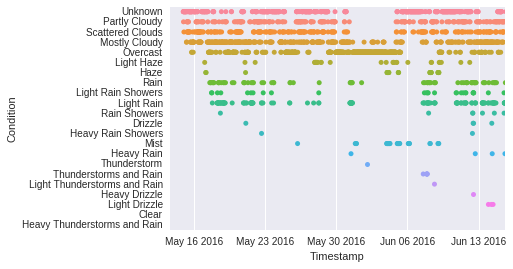

In [106]:
ax = sns.stripplot(data=weather_dataset, x='Timestamp', y='Condition', orient='h');
print ax.get_xlim()
ax.set_xlim((736097.65688844072,736130.55144489254))

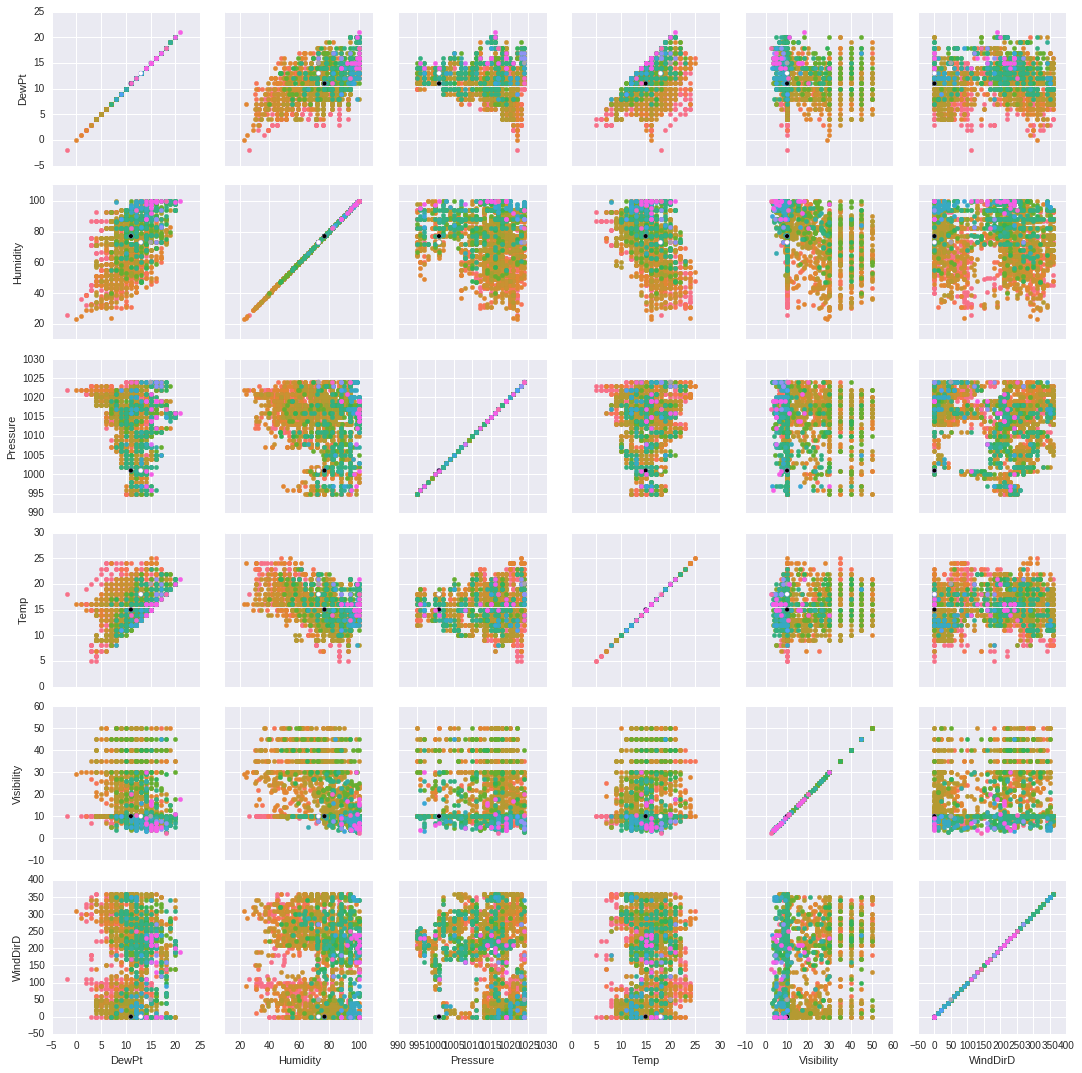

In [107]:
g = sns.PairGrid(data=weather_dataset, hue='Condition', vars=['DewPt', 'Humidity', 'Pressure', 'Temp', 'Visibility', 'WindDirD'])
g = g.map(plt.scatter)

**Can we do a classification model to interpolate the condition?**
Yes

**Is it worth it?**
Not sure because it would be a 'proxy' feature for all the other weather features

**Conclusion:** Drop the column

In [108]:
#weather_dataset.drop(['Condition'], axis=1, inplace=True)

## Build Dataset

In [109]:
weather_dataset.head()

,Condition,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindSpeed
0,NaN,4.0,0,0,61.0,1023.0,0,0,9.0,0,2016-05-14 23:00:00+00:00,0,25.0,50.0,5.6
1,Unknown,3.0,0,0,71.0,1023.0,0,0,8.0,0,2016-05-14 23:20:00+00:00,0,10.0,100.0,5.6
2,Unknown,3.0,0,0,71.0,1023.0,0,0,8.0,0,2016-05-14 23:50:00+00:00,0,10.0,80.0,5.6
3,Partly Cloudy,4.0,0,0,74.0,1023.0,0,0,7.0,0,2016-05-15 00:00:00+00:00,0,25.0,90.0,5.6
4,Unknown,3.0,0,0,71.0,1023.0,0,0,8.0,0,2016-05-15 00:20:00+00:00,0,7.0,0.0,3.7


In [110]:
weather_dataset.describe()

,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Tornado,Visibility,WindDirD,WindSpeed
count,3150.000000,3150.0,3150.0,3150.000000,3150.000000,3150.000000,3150.0,3150.000000,3150.0,3150.0,3150.000000,3150.000000,3150.000000
mean,11.013333,0.0,0.0,75.968094,1014.792358,0.136190,0.0,15.191112,0.0,0.0,14.739098,174.173019,12.804499
std,3.249596,0.0,0.0,16.369508,6.942237,0.343045,0.0,3.423207,0.0,0.0,10.167668,117.527075,5.510357
min,-2.000000,0.0,0.0,21.000000,995.000000,0.000000,0.0,5.000000,0.0,0.0,2.500000,0.000000,0.000000
25%,9.000000,0.0,0.0,64.000000,1012.000000,0.000000,0.0,13.000000,0.0,0.0,10.000000,50.000000,9.300000
50%,11.000000,0.0,0.0,79.000000,1017.000000,0.000000,0.0,15.000000,0.0,0.0,10.000000,210.000000,13.000000
75%,13.000000,0.0,0.0,88.000000,1020.000000,0.000000,0.0,18.000000,0.0,0.0,15.000000,270.000000,16.700001
max,21.000000,0.0,0.0,100.000000,1024.000000,1.000000,0.0,25.000000,0.0,0.0,50.000000,360.000000,33.299999


In [111]:
weather_dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 15 columns):
Condition     3014 non-null object
DewPt         3150 non-null float32
Fog           3150 non-null int8
Hail          3150 non-null int8
Humidity      3150 non-null float32
Pressure      3150 non-null float32
Rain          3150 non-null int8
Snow          3150 non-null int8
Temp          3150 non-null float32
Thunder       3150 non-null int8
Timestamp     3150 non-null datetime64[ns, UTC]
Tornado       3150 non-null int8
Visibility    3150 non-null float32
WindDirD      3150 non-null float32
WindSpeed     3150 non-null float32
dtypes: datetime64[ns, UTC](1), float32(7), int8(6), object(1)
memory usage: 434.1 KB


In [112]:
pickle.dump(weather_dataset, open("data/parsed/weather_dataset_utc.p", "wb"))